In [1]:
################################
#### IMPORTS AND INICIALIZATIONS
################################

import re
import pandas as pd
import numpy as np
from keras.models import Model
from keras.layers import Input, Dense
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

data = 'RAVEN/TrialRightWrong/Trial'

# All the files we need
files = ['/DEI_trial_by_trial_Right.xlsx', 
         '/DEI_trial_by_trial_Wrong.xlsx', 
         '/esec_trial_by_trial_Right.xlsx',
         '/esec_trial_by_trial_Wrong.xlsx']
genreFile = 'RAVEN/Informação_género.txt'

# Initialize a dict for aggregate the values for training and testing
values = { 'TRAINING': {}, 'TESTING': {} }

Using TensorFlow backend.


In [2]:
####################################
#### EXTRACT DATA AND PRE-PROCESSING
####################################

for file in files:
    
    # For each file
    f = pd.ExcelFile(data+file)

    # For each Train
    for sheet in f.sheet_names:
        
        df = pd.read_excel(f,  sheet_name=sheet)
        
        category = 'TRAINING' if 'TRAINING' in sheet \
                                else 'TESTING' \
                                    if 'TESTING' in sheet \
                                        else None  
        
        # Get all values for each person
        # In the 'unnamed:22' column is where person id is
        # Notice that if a person isn't in the 'right files', so he is in the 'wrong files' 
        if category and df.shape[0] > 0:
            dataValues = values[category]

            for index, row in df[df.columns].iterrows():
                # cell = [genre, course, value_each_characteristic, correct(1)/incorret(0)]
                *rest,id = row 
                cell = [int("DEI" in id)] #[int(row[0]=="DEI"),sheet, row[1]]
                cell += rest
                cell += [1 if (file=='/DEI_trial_by_trial_Right.xlsx' or file=='/esec_trial_by_trial_Right.xlsx') else 0]
     
                if (id not in values):
                    dataValues[id] = [cell]
                else:
                    dataValues[id] += [cell] 
                    
# Extract the genre from genreFile
with open(genreFile, "r") as f:
    
    # For each file get the information about person_id, genre and the number of correct answers in the trials.
    for l in f:
        l = l.strip()
        if l=="" or '--' in l:continue
        id, genre, rest = l.split(' - ')
        
        correct = int(re.search(r'\d+', rest).group())
        if id[-2] == '_': id = id[:-1] + '0' + id[-1]
        for dataDict in [values['TRAINING'], values['TESTING']]: # Get dictionaries 'train and test'
            for i in range(len(dataDict[id])):
                dataDict[id][i][:0] = [int(genre=='Masculino')] # Add the genre in the begining of the cell  
                dataDict[id][i][-1:-1] = [correct] # Add the number of right answers 

    

# For each person ( PERSON : list([genre, course, characteristic_value, correct/incorrect ]))        
items = { 'TRAINING': [], 'TESTING': [] }

for dataType in ['TRAINING','TESTING']:
    for v in values[dataType].values():
        items[dataType] += v

items['TRAINING'] = np.matrix(items['TRAINING'])
items['TESTING'] = np.matrix(items['TESTING'])

# Changing missing values in Training for the average
Itrain = items['TRAINING']   
col_mean = np.nanmean(Itrain, axis=0)
inds = np.where(np.isnan(Itrain))
Itrain[inds] = np.take(col_mean, inds[1])

# Scales and Translates each feature individually such that it is in the given range on the training set
scaler = MinMaxScaler()
scaler.fit(Itrain[:,:-1])

# Changing missing values in Testing for the average
Itest = items['TESTING']   
col_mean = np.nanmean(Itest, axis=0)
inds = np.where(np.isnan(Itest))
Itest[inds] = np.take(col_mean, inds[1])

data_trainX = scaler.transform(Itrain[:,:-1])
data_trainY = Itrain[:,-1]

data_testX = scaler.transform(Itest[:,:-1])
data_testY = Itest[:,-1] 

print(data_trainX)
print(data_trainY.T)

print(data_testX)
print(data_testY.T)

[[0.         1.         0.17421668 ... 0.68394851 0.00180639 0.85714286]
 [0.         1.         0.23085294 ... 0.69370773 0.12850779 1.        ]
 [1.         1.         0.29785588 ... 0.64882199 0.02234868 1.        ]
 ...
 [1.         0.         0.1907411  ... 0.99761179 0.18617211 0.42857143]
 [0.         0.         0.25026328 ... 0.6595733  0.00679645 0.42857143]
 [1.         0.         0.21798322 ... 0.66558289 1.         0.85714286]]
[[0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
[[1.         1.         0.16808048 ... 1.08844968 0.05304196 0.85714286]
 [0.         1.         0.1638333  ... 0.68425385 0.08870713 0.85714286]
 [0.         1.         0.16146379 ... 0.696217   0.13674616 1.        ]
 ...
 [0.         0.         0.06227911 ... 0.6898565  0.0934017  0.57142857]
 [0.         0.         0.43783983 ... 0.63304205 0.00479417 0.42857143]
 [0.         0.         0.2094143  ... 0.       

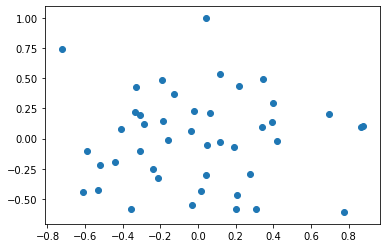

In [3]:
################################
########################### PCA
################################

pca = PCA(n_components=2)
pcaData = pca.fit_transform(data_trainX[:,2:-1])

plt.scatter(pcaData[:,0], pcaData[:,1])

plt.show()

In [4]:
################################
################ NEURAL NETWORK
################################

inputs = Input(shape=(data_trainX.shape[1],))
x = Dense(32, activation='relu')(inputs)
x = Dense(8, activation='relu')(x)
x = Dense(8, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

model.fit(data_trainX, data_trainY, epochs=16, batch_size=4)
predicts = model.predict(data_testX)>0.5
print('accuracy:',(predicts==data_testY).sum()/predicts.shape[0])








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/16





44/44 [==============================] - 1s 15ms/step - loss: 0.6223 - acc: 0.8182
Epoch 2/16
44/44 [==============================] - 0s 438us/step - loss: 0.5783 - acc: 0.8182
Epoch 3/16
44/44 [==============================] - 0s 435us/step - loss: 0.5424 - acc: 0.8182
Epoch 4/16
44/44 [==============================] - 0s 433us/step - loss: 0.5176 - acc: 0.8182
Epoch 5/16
44/44 [==============================] - 0s 419us/step - loss: 0.5053 - acc: 0.8182
Epoch 6/16
44/44 [==============================] - 0s 424us/step - loss: 0.4953 - acc: 0.8182
Epoch 7/16
44/44 [==============================] - 0s 413us/step - loss: 0.4877 - acc: 0.8182
Epoch 8/16
44/44 [==============================] - 0s 432us/step - loss: 0.4802 - acc: 0.8182
Epoch 9/16
44/44 [==============================] - 0s 446us/step - loss: 0.4737 - acc: 0.8182
Epoch 10/16
44/44 [====================

In [5]:
################################
####### NORMALIZE AND AGGREGATE
################################

avg = []
course_genre = []
correct = []

group = dataX[:, 0]+dataX[:, 1]*2
cg, count = np.unique(group, return_counts=True)

for t,c in zip(cg,count):
    validClass = (group == t) #True if it belongs to group genre/course
    fadigue = validClass * data_trainX[:,2]

    correctAnswers = validClass.T * data_trainY
    percCorrectAnswers = correctAnswers.sum()/c
    correct.append(percCorrectAnswers*100)

    avg.append(fadigue.sum()/c)
    course_genre.append(t)

print('Course with Genre:',course_genre, ', Avg:', avg)


NameError: name 'dataX' is not defined

In [ ]:
################################
#### PLOT INFO 
################################

# Fatigue Values for the each course and each genre
%matplotlib inline

x = ['ESEC AND FEMIN','ESEC AND MASC', 'DEI AND FEMIN', 'DEI AND MASC']
y = course_genre
plt.figure(figsize=(15,12))
plt.bar(x,y)
plt.title("Fatigue Values for the each course and each genre")
plt.xlabel('Each course with each genre')
plt.xticks(fontsize=9 , rotation=30)
plt.ylabel('Mean Fatigue Value')
plt.show()

# % of correct answers for the each course and each genre

plt.figure(figsize=(15,12))
y = correct
plt.bar(x,y)
plt.title("% of correct answers for the each course and each genre")
plt.xlabel('Each course with each genre')
plt.xticks(fontsize=9 , rotation=30)
plt.ylabel('% of correct answers')
plt.show()